### Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np
import json
import datetime
import matplotlib.pyplot as plt

In [2]:
login = pd.read_json('logins.json')

In [3]:
login.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [4]:
login.tail()

,login_time
93137,1970-04-13 18:50:19
93138,1970-04-13 18:43:56
93139,1970-04-13 18:54:02
93140,1970-04-13 18:57:38
93141,1970-04-13 18:54:23


In [5]:
login.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


Our one datatype is datetime

In [6]:
login['count'] =1
login = login.set_index(pd.to_datetime(login['login_time'], unit='s'))[['count']]
login.head()

,count
login_time,
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:37,1
1970-01-01 20:16:36,1
1970-01-01 20:26:21,1


## Processing the data into 15 minute chunks

In [7]:
login_agg = login.resample('15min').sum()

In [8]:
login_agg.head()

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


In [9]:
login_agg['count'].sum()

93142

In [10]:
login_agg.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9788 entries, 1970-01-01 20:00:00 to 1970-04-13 18:45:00
Freq: 15T
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   count   9788 non-null   int64
dtypes: int64(1)
memory usage: 152.9 KB


## Visualizing the Data

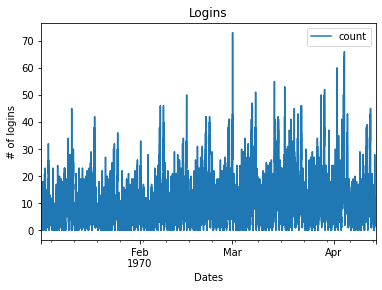

In [11]:
login_agg.plot()
plt.xlabel('Dates')
plt.ylabel('# of logins')
plt.title('Logins')
plt.show()

Hard to see much from the graph above. Lets smooth it out

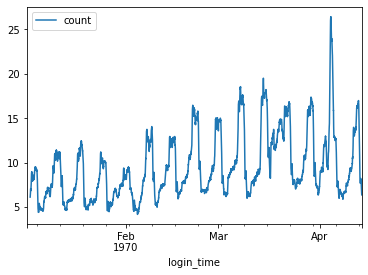

In [12]:
login_agg.rolling(window=95).mean().plot()
plt.show()

This is a much better representation over a 4 month period

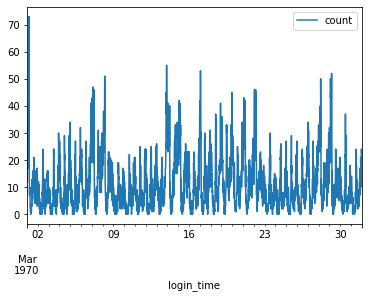

In [13]:
login_agg.loc['1970-03'].plot()
plt.show()

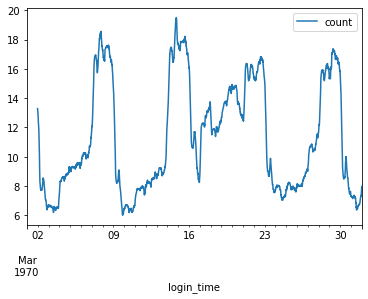

In [14]:
login_agg.loc['1970-03'].rolling(window=95).mean().plot()
plt.show()

We can see a rise towards the end of weeks. 

In [15]:
datetime.datetime(1970, 3, 1).weekday()

6

I wanted to see what day is March 1 to reference that point. Looks like it is Sunday. 

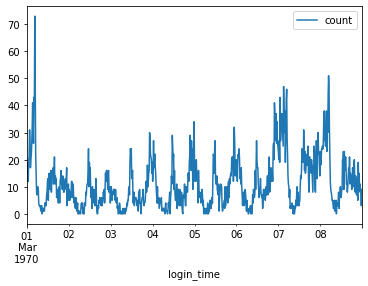

In [16]:
login_agg.loc['1970-03-01': '1970-03-08'].plot()
plt.show()

Here is to reiterate again we see an increase on the weekends.

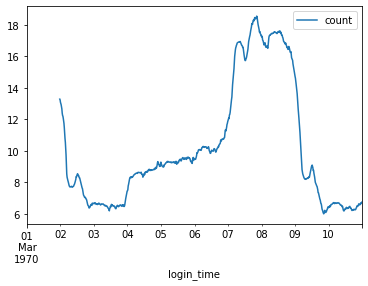

In [17]:
login_agg.loc['1970-03-01':'1970-03-10'].rolling(window=95).mean().plot()
plt.show()

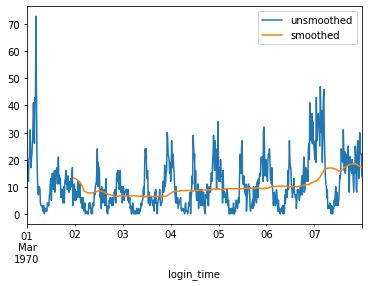

In [18]:
unsmoothed = login_agg['count']['1970-03-01':'1970-03-07']
smoothed = unsmoothed.rolling(window=95).mean()
one_week = pd.DataFrame({'unsmoothed':unsmoothed, 'smoothed': smoothed})
one_week.plot()
plt.show()

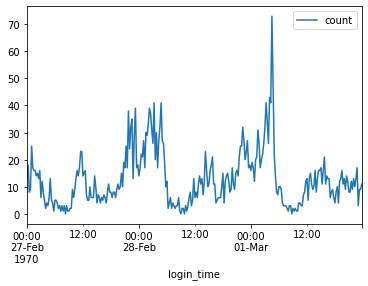

In [19]:
login_agg.loc['1970-02-27':'1970-03-01'].plot()
plt.show()

I plotted one weekend to see how much it increases on Sundays. 

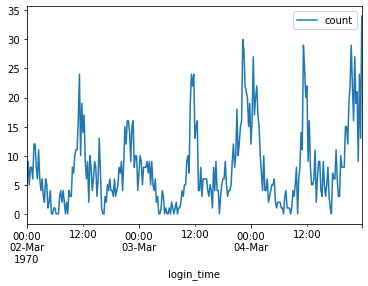

In [20]:
login_agg.loc['1970-03-02':'1970-03-04'].plot()
plt.show()

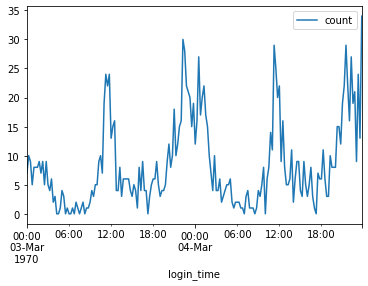

In [21]:
login_agg.loc['1970-03-03':'1970-03-04'].plot()
plt.show()

We see from the last two graphs that the spikes are at noon and midnight. 

## Experiment and Metrics Design

I think the key metric of success of this experiment in encouraging driver partners to serve both cities is weekday activity.
This can be measured with ease and the data can be gathered easily as well. I would do some sort Hypthesis testing where the null involves no difference in the cars entering bridge during the weekday and the alternative being is there an increase in cars entering the bridge from Gotham. I would also do the same thing but for weeknights as well. If the p-value is less than .01 for both test, I would reject the null hypothesis. If it is greater than .05, I would fail to reject the hypothesis. If only one test is rejected and the other is not we would have to go further into detail. 

# Predictive Modeling

In [23]:
!pip install xgboost

In [49]:
import seaborn as sns
import pandas as pd
import json
import numpy as np
import sklearn
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, cv, plot_importance

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [26]:
data = pd.read_json('ultimate_data_challenge.json')

In [27]:
data.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [28]:
data.tail()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
49995,King's Landing,0,2014-01-25,5.0,1.0,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2
49996,Astapor,1,2014-01-24,NaN,1.0,2014-01-25,iPhone,0.0,False,0.0,0.00,4.0
49997,Winterfell,0,2014-01-31,5.0,1.0,2014-05-22,Android,0.0,True,100.0,3.86,5.0
49998,Astapor,2,2014-01-14,3.0,1.0,2014-01-15,iPhone,0.0,False,100.0,4.58,3.5
49999,Astapor,0,2014-01-18,NaN,1.0,2014-04-20,Android,0.0,False,0.0,3.49,5.0


In [29]:
data.columns

Index(['city', 'trips_in_first_30_days', 'signup_date', 'avg_rating_of_driver',
       'avg_surge', 'last_trip_date', 'phone', 'surge_pct',
       'ultimate_black_user', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver'],
      dtype='object')

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [32]:
data.shape

(50000, 12)

In [33]:
data.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [34]:
data.last_trip_date[0]

'2014-06-17'

In [35]:
data.last_trip_date = pd.to_datetime(data.last_trip_date)
data.signup_date = pd.to_datetime(data.signup_date)

In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    41878 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

In [37]:
data['last_trip_date'].describe()

C:\Users\bsnus\.conda\envs\Decision Tree\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


count                   50000
unique                    182
top       2014-06-29 00:00:00
freq                     2036
first     2014-01-01 00:00:00
last      2014-07-01 00:00:00
Name: last_trip_date, dtype: object

In [39]:
june_users = (data.last_trip_date >= '2014-06-01').sum() / (data.last_trip_date >= '2014-06-01').count()
june_users

0.37608

In [40]:
data['june_percent'] = (data.last_trip_date >= '2014-06-01')*1
data.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,june_percent
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000,50000.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158,0.376080
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652,0.484405
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000,0.000000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000,0.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000,1.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000,1.000000


In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    41878 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
 12  june_percent            50000 non-null  int32 

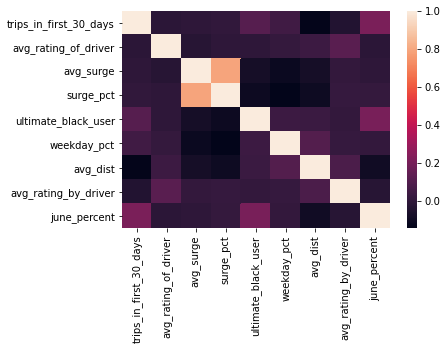

In [42]:
fig = plt.figure()
ax = plt.subplot(111)
corr = data.corr()
ax = sns.heatmap(corr)
plt.show()

In [43]:
corr['june_percent'].sort_values(ascending=False)

june_percent              1.000000
trips_in_first_30_days    0.210463
ultimate_black_user       0.205002
surge_pct                 0.011797
weekday_pct               0.009693
avg_surge                -0.003333
avg_rating_of_driver     -0.011653
avg_rating_by_driver     -0.026791
avg_dist                 -0.092780
Name: june_percent, dtype: float64

In [45]:
data.city.value_counts()

Winterfell        23336
Astapor           16534
King's Landing    10130
Name: city, dtype: int64

In [46]:
data.phone.value_counts()

iPhone     34582
Android    15022
Name: phone, dtype: int64

In [47]:
(data.phone[data.phone.isnull()]).value_counts()

Series([], Name: phone, dtype: int64)

In [48]:
data.phone.fillna('Additional', inplace=True)
data.phone.value_counts()

iPhone        34582
Android       15022
Additional      396
Name: phone, dtype: int64

In [50]:
data = pd.DataFrame(data)

In [61]:
data['signup_date'] = pd.to_datetime(data['signup_date'])
data['last_trip_date'] = pd.to_datetime(data['last_trip_date'])

In [51]:
last_30 = data.last_trip_date.max()

In [52]:
data['active_status'] = (data.last_trip_date > last_30).astype('int')

In [53]:
data = pd.get_dummies(data, columns = ['city', 'phone'])

In [54]:
active_user = data[data.active_status == 1]
inactive_user = data[data.active_status == 0]

In [57]:
feature_columns = ['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge',
 'surge_pct', 'ultimate_black_user', 'weekday_pct', 'city_Astapor',
 "city_King's Landing", 'city_Winterfell', 'phone_Android','phone_iPhone']
stats_dict = {}
for col in feature_columns:
    stats_dict[col] = [active_user[col].mean(), active_user[col].std(),
                       inactive_user[col].mean(),inactive_user[col].std()]

In [58]:
stats_df = pd.DataFrame.from_dict(stats_dict, orient='index').rename(columns = {0:'active_mean', 1:'active_std', 2:'inactive_mean', 3:'inactive_std'})

Text(0.5, 1.0, 'Average of Features for Active and Inactive Users')

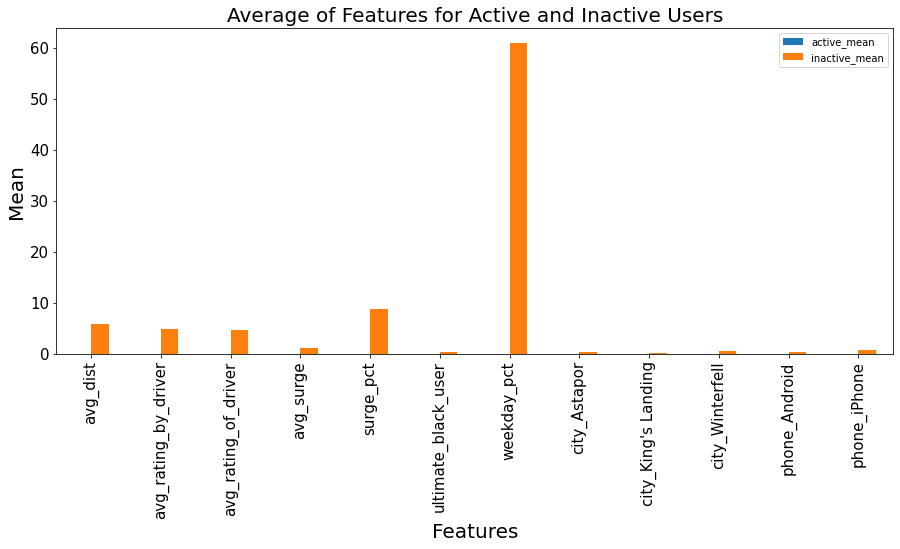

In [62]:
stats_df[['active_mean', 'inactive_mean']].plot(kind = 'bar', yerr=stats_df[['active_std','inactive_std']], figsize = (15,6), fontsize = 15)
plt.xlabel('Features',fontsize = 20)
plt.ylabel('Mean', fontsize = 20)
plt.title('Average of Features for Active and Inactive Users', fontsize = 20)

In [64]:
# define features and target
X = data[feature_columns]
y = data.active_status
# split training and test data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=123)

In [65]:
# dictionary of parameters to optimize, and the range of optimization values
parameters = {
    'max_delta_step':[0,0.05],
    'scale_pos_weight':[0.95, 0.9],
    'subsample':[1,0.8],
    'learning_rate': [0.25, 0.2, 0.1],
    'min_child_weight':[0,1,2],
    'gamma':[1, 2, 3]
    }

In [66]:
# instantiate classifier
xg_clf = XGBClassifier(objective = 'binary:logistic', random_state = 42, silent = 1, n_estimators=10, max_depth= 8)

# RandomSearch
grid_search = GridSearchCV(param_grid= parameters, estimator = xg_clf, cv=3, scoring='accuracy')
grid_search.fit(X_train,y_train)

[17:14:09] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:14:10] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:14:10] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings bu

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
       colsample_bynode=None, colsample_bytree=None, gamma=None,
       gpu_id=None, importance_type='gain', interaction_constraints=None,
       learning_rate=None, max_delta_step=None, max_depth=8,
       min_child_weig...t=None, silent=1, subsample=None,
       tree_method=None, validate_parameters=None, verbosity=None),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_delta_step': [0, 0.05], 'scale_pos_weight': [0.95, 0.9], 'subsample': [1, 0.8], 'learning_rate': [0.25, 0.2, 0.1], 'min_child_weight': [0, 1, 2], 'gamma': [1, 2, 3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [67]:
# Print best parameters and results
print(grid_search.best_params_)
print(grid_search.best_score_)

{'gamma': 1, 'learning_rate': 0.25, 'max_delta_step': 0, 'min_child_weight': 0, 'scale_pos_weight': 0.95, 'subsample': 1}
1.0


In [70]:
xg_clf_opt = XGBClassifier(**optimized_parameters)
xg_clf_opt.fit(X_train, y_train)

[17:18:19] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=3, gpu_id=-1,
       importance_type='gain', interaction_constraints='',
       learning_rate=0.2, max_delta_step=0, max_depth=8,
       min_child_weight=1, missing=nan, monotone_constraints='()',
       n_estimators=10, n_jobs=0, num_parallel_tree=1,
       objective='binary:logistic', random_state=42, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=0.95, silent=0, subsample=1,
       tree_method='exact', validate_parameters=1, verbosity=None)

In [69]:
optimized_parameters = {'objective':'binary:logistic',
                        'n_estimators': 10,
                        'random_state': 42,
                        'silent': 0,
                        'subsample': 1, 
                        'scale_pos_weight': 0.95, 
                        'min_child_weight': 1, 
                        'max_depth': 8, 
                        'max_delta_step': 0, 
                        'learning_rate': 0.2, 
                        'gamma': 3
                       }

In [71]:
# predict the labels
y_opt_pred = xg_clf_opt.predict(X_train)
# score model
score = accuracy_score(y_train, y_opt_pred)
# print accuracy
print("The resulting accuracy of the optimized classifier is {}.".format(round(score,4)))

The resulting accuracy of the optimized classifier is 1.0.


In [72]:
# train unoptimized model
xg_clf.fit(X_train, y_train)
# predict the labels of unoptimized model
y_unopt_pred = xg_clf.predict(X_train)
# score model
un_score = accuracy_score(y_train, y_unopt_pred)
# print accuracy
print("The resulting accuracy of the unoptimized classifier is {}.".format(round(un_score,4)))

[17:20:31] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


The resulting accuracy of the unoptimized classifier is 1.0.


In [73]:
# predict the labels
y_opt_test = xg_clf_opt.predict(X_test)
# score model
test_score = accuracy_score(y_test, y_opt_test)
# print accuracy
print("The resulting accuracy of the optimized classifier for the test set is {}.".format(round(test_score,4)))

The resulting accuracy of the optimized classifier for the test set is 1.0.


In [74]:
# predict the labels of unoptimized model using the test set
y_unopt_test = xg_clf.predict(X_train)
# score model
test_score = accuracy_score(y_train, y_unopt_test)
# print accuracy
print("The resulting accuracy of the unoptimized classifier is {}.".format(round(test_score,4)))

The resulting accuracy of the unoptimized classifier is 1.0.


In [76]:
import pickle

In [77]:
# instantiate classifier
xg_clf_final = XGBClassifier(objective = 'binary:logistic', random_state = 42, silent = 1, n_estimators=200, max_depth= 8)
# train final model
xg_clf_final.fit(X, y)
# save model
pickle.dump(xg_clf_final, open('final_model.pickle', 'wb'))

[17:21:23] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [79]:
plot_importance(xg_clf_final)

ValueError: Booster.get_score() results in empty.  This maybe caused by having all trees as decision dumps.

When doing the feature importance, average distance happened to be the most important feature after a signup. 